Device types (tasks) with alter are:  {3: '0', 2: '1', 1: '1'}
Root node:  3  dist:  {'0': 0.7845728720010069, '1': 0.7845728720010069}
[{2: '0', 1: '0'}, {2: '0', 1: '1'}, {2: '1', 1: '0'}, {2: '1', 1: '1'}]
[[{2: '0', 1: '0'}, {2: '0', 1: '1'}], [{2: '1', 1: '0'}, {2: '1', 1: '1'}]]
['0', '0', 0.23208063390719058]
['0', '1', 0.7679193660928094]
NOT  candidate  {2: '1', 1: '0'}  prob: 0.15000000000000002
Best candidate  {2: '1', 1: '1'}  prob: 0.85
[{3: '0', 2: '0'}, {3: '0', 2: '1'}, {3: '1', 2: '0'}, {3: '1', 2: '1'}]
[[{3: '0', 2: '0'}, {3: '0', 2: '1'}], [{3: '1', 2: '0'}, {3: '1', 2: '1'}]]
NOT  candidate  {3: '0', 2: '0'}  prob: 0.15000000000000002
Best candidate  {3: '0', 2: '1'}  prob: 0.85
['1', '0', 0.5878372302663417]
['1', '1', 0.4121627697336582]
[{3: '0', 0: '0'}, {3: '0', 0: '1'}, {3: '1', 0: '0'}, {3: '1', 0: '1'}]
[[{3: '0', 0: '0'}, {3: '0', 0: '1'}], [{3: '1', 0: '0'}, {3: '1', 0: '1'}]]
['0', '0', 0.7498801921876748]
['0', '1', 0.25011980781232535]
['1', '0', 0.613

/usr/pkg/lib/python3.7/site-packages/ipykernel_launcher.py:97: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


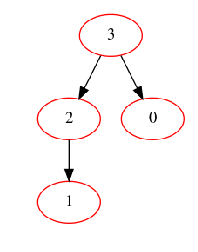

In [45]:
from pomegranate import BayesianNetwork

import networkx as nx
from random import randint
import random
import itertools
import numpy as np

# This module build BN where a set of variables will have max joint probability. 
# We call it here task. 
# https://stats.stackexchange.com/questions/390042/build-a-bayesian-network-to-make-a-set-of-random-variables-have-maximum-joint-pr
class RandomDAG:
    def __init__(self, n_nodes, n_edges):

        self.n_nodes = n_nodes
        self.n_edges = n_edges

        if n_edges > n_nodes * (n_nodes - 1):
            self.n_edges = n_nodes * (n_nodes - 1)

        self.randDAG = nx.DiGraph()

    # connected graph req (n-1) edges at least
    # DAG can't be more than n(n-1) edges
    # https://ipython.org/ipython-doc/3/parallel/dag_dependencies.html

    def random_dag(self):

        """Generate a random Directed Acyclic Graph (DAG) with a given number of nodes and edges."""
        # add nodes, labeled 0...nodes:
        for i in range(self.n_nodes):
            self.randDAG.add_node(i)

        child_parent = {}

        # to avoid infinit loop, need to have better solution
        round = 1000
        while self.n_edges > 0 and round > 0:
            round -= 1

            a = randint(0, self.n_nodes - 1)
            b = a
            while b == a or self.randDAG.has_edge(a, b):
                b = randint(0, self.n_nodes - 1)
            self.randDAG.add_edge(a, b)
            if nx.is_directed_acyclic_graph(self.randDAG):
                self.n_edges -= 1
                parent = child_parent.get(b)
                if parent is None:
                    parent = [a]
                else:
                    parent.append(a)
                child_parent[b] = parent
                # print(a,"-> ", b)
            else:
                # we closed a loop!
                self.randDAG.remove_edge(a, b)
        return self.randDAG, child_parent


# from https://github.com/jmschrei/pomegranate/blob/master/examples/bayesnet_asia.ipynb
class User_model:
    def __init__(self, n_nodes, n_alters, n_edges, is_gen_task):
       
        self.n_nodes = n_nodes
        self.n_alters = n_alters
        self.n_edges = n_edges
        self.is_gen_task = is_gen_task
        # assert (n_edges < (n_nodes-1)*(n_nodes-2)/2), " Large number of edges, reduce them please!"
        self.alters_list = self.get_alter_list(n_alters)
        self.task_dict = {}
        
        self.network = self.get_BN()
        self.network.bake()

    def get_alter_list(self, n_alter):
        " used in getCondProb and get_score"
        return [str(c) for c in range(n_alter)]

    def get_nodes_prob_dist(self, node_without_parents, child_parent):
        node_prob_dict = {}

        for node in node_without_parents:
            p = np.random.random(self.n_alters)
            p /= p.sum()
            # now the sum of p is 1

            dist = {}
            if node not in self.task_dict.keys():
                dist = dict(zip(map(str, range(self.n_alters)), p))
            else:  # set max prob to the perfered alter
                pref_alter = self.task_dict[node]
                dist[pref_alter] = np.amax(p)
                # remove best_alter from alter and set the rest of the prob to them
                alt_list = list(map(str, list(range(self.n_alters))))
                alt_list.remove(pref_alter)
                np.delete(p, np.amax(p))
                dist.update(dict(zip(alt_list, p)))

            # save node with its prob
            node_prob_dict[str(node)] = dist

            print("Root node: ", node, " dist: ", dist)

        # these nodes have parents, generate CPT for them
        for node, parent_lst in child_parent.items():
            # parents + this node condProbTable
            condProbTable = self.getCondProbTable(node, parent_lst, self.n_alters)
            # save node with its prob
            node_prob_dict[str(node)] = condProbTable
        return node_prob_dict

    #            print("Conditional Probability Table: node, parent", node," - ", parent_lst, " \n", condProbTable)

    # n_types: number devices types (e.g. door_lock, camera, etc)
    # n_alter: number of devices from same type
    # n_types: number devices types (e.g. door_lock, camera, etc)
    # n_alter: number of devices from same type
    def get_BN(self):

        # 1 Build BN DAG structure
        rand_dag = RandomDAG(self.n_nodes, self.n_edges)
        DAG, child_parent = rand_dag.random_dag()

        ################################################
        if self.is_gen_task:
            selected_task = nx.dag_longest_path(DAG)
            random_preference = [random.choice(self.alters_list) for i in selected_task]
            self.task_dict = dict(zip(selected_task, random_preference))
            print("Device types (tasks) with alter are: ", self.task_dict)

        ################################################

        nodes_list = list(range(self.n_nodes))
        node_with_parent_lst = child_parent.keys()
        node_without_parents = [e for e in nodes_list if e not in node_with_parent_lst]

        # 2 Build BN probability model
        # 2.1 get probabilityDist or conditional prob table
        # node_prob_dict = self.get_nodes_prob_dist(node_without_parents,child_parent)
        # consider selected task
        node_prob_dict = self.get_nodes_prob_dist(node_without_parents, child_parent)

        # 2.2 Create nodes linked to its parent, parent should be processed first.
        # all node state saved to be added to the BN later
        nodes_state = {}
        # all node dist or CPT saved to link child to parents when building child CPT
        nodes_dist = {}

        # start with root nodes (don't have parents then link child to them)
        for node in node_without_parents:
            prob_dist = node_prob_dict[str(node)]
            node_dist = DiscreteDistribution(prob_dist)
            nodes_dist[node] = node_dist
            nodes_state[node] = State(node_dist, name=str(node))
            # remove from nodes_list
            nodes_list.remove(node)

        # rest of the node should have parents
        while len(nodes_list) > 0:
            for node, parent_lst in child_parent.items():
                # if node's parents already created then it can be created now
                if set(parent_lst).issubset(nodes_state.keys()) and node in nodes_list:
                    node_dist = ConditionalProbabilityTable(node_prob_dict[str(node)] \
                                                            , [nodes_dist[i] for i in parent_lst])

                    nodes_dist[node] = node_dist
                    nodes_state[node] = State(node_dist, name=str(node))
                    # remove from the node_list
                    nodes_list.remove(node)

        # 3 Create BN and add the nodes_state
        self.network = BayesianNetwork("User_pref")
        for node, state in nodes_state.items():
            self.network.add_node(state)

        # 4 Link nodes with edges using nodes_state and DAG.edge
        for a, bs in DAG.edge.items():
            for b in bs.keys():
                self.network.add_edge(nodes_state[a], nodes_state[b])
        #       print("Network has ", self.network.node_count() , " nodes and ", self.network.edge_count(), " edges")
        return self.network

    def get_score(self, cand_list):
        can_dev = []

        for node_id in range(self.n_nodes):
            is_added = False
            for node_alter_id in range(self.n_alters):
                if node_id * self.n_alters + node_alter_id in cand_list:
                    can_dev.append(self.alters_list[node_alter_id])
                    is_added = True
            if not is_added:
                can_dev.append(None)

        score = self.network.probability(can_dev)

        return score, can_dev

    def get_permutation_groups(self, parent_node_lst, n_att):
        var_att_dict = {}
        for i in range(len(parent_node_lst)):
            var_att_dict[i] = self.alters_list
            # list(range(n_att))

        permutation = list(dict(zip(parent_node_lst, x)) \
                           for x in itertools.product(*var_att_dict.values()))
        print(permutation)
        n_prob_groups = int(len(permutation)/n_att)
        perm_groups = [[] for i in range(n_prob_groups)]
        c = 0
        for perm in permutation:
            # add to the begining
            perm_groups[c // n_att].append(perm)
            c += 1
        return perm_groups

    def getCondProbTable(self, node, parent_lst, n_att):
        parent_node_lst = []
        parent_node_lst.extend(parent_lst)
        parent_node_lst.append(node)
        perm_groups = self.get_permutation_groups(parent_node_lst, n_att)

        # print(parent_node_lst,": ",permutation, ", ", len(permutation), " <CDP>\n")
        print(perm_groups)
        condProbTable = []
        
        maxp_for_best_alter = 1.7 / n_att
        if self.is_gen_task:
            intersect_dict = {k: v for k, v in self.task_dict.items() if k in parent_node_lst}
                
        # for each permutation generate prob such that the sum of each node CDP is = 1
        for i in range(len(perm_groups)):

            if self.is_gen_task and len(intersect_dict) > 1 and \
             [True for j in range(n_att) if intersect_dict.items() <= perm_groups[i][j].items()] :
                
                # print(intersect_dict)
                # generate p such that one value is                
                rem_alt = n_att - 1
                rest_prob = np.random.random(rem_alt)
                rest_prob /= sum(rest_prob)
                rest_prob *= (1 - maxp_for_best_alter)
                
                # the sum of maxp_for_best_alter and rest_prob = 1
                for j in range(n_att):
                    # alter_idx = i * n_att + j
                    condProbRow = list(perm_groups[i][j].values())
                    if intersect_dict.items() <= perm_groups[i][j].items():
                        print("Best candidate ", perm_groups[i][j], " prob:", maxp_for_best_alter)
                        condProbRow.append(maxp_for_best_alter)
                    else:
                        rem_alt -= 1
                        print("NOT  candidate ", perm_groups[i][j], " prob:", rest_prob[rem_alt])
                        condProbRow.append(rest_prob[rem_alt])

                    condProbTable.append(condProbRow)

            else:
                # to gurantee best alter, no others should have prob> maxp
                a = np.random.random(n_att)
                a /= a.sum()
                while self.is_gen_task and np.amax(a) >= maxp_for_best_alter:
                    a = np.random.random(n_att)
                    a /= a.sum()
                    
                # to make sum of alter prob = 1
                for j in range(n_att):
                    condProbRow = list(perm_groups[i][j].values())
                    condProbRow.append(a[j])
                    print(condProbRow)
                    condProbTable.append(condProbRow)                

        return condProbTable


user_model = User_model(n_nodes=4, n_alters=2, n_edges=3, is_gen_task = True)
network = user_model.network
network.bake()
alt= ['0','1']
dev = [1,2,3,4]
per = itertools.product(*[['0','1'],['0','1'],['0','1'],['0','1']])
for r in per:
    print(r,":", network.probability(list(r)))
network.plot()
